In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image 

import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot as plt
from datetime import datetime
import time
from tqdm import tqdm
import time

In [81]:
log_data = pd.read_csv("./../data/log_data_pre") # log_data에 대해서 전처리한 데이터를 사용 (결측치 대체, 행동명 매핑, 행동일시 slicing)
user_spec = pd.read_csv("./../data/user_spec.csv") 
loan_result = pd.read_csv("./../data/loan_result.csv")

In [125]:
log_data.drop("Unnamed: 0",axis=1,inplace = True)

In [131]:
loan_result.columns=['신청서_번호', '한도조회_일시', '금융사_번호', '상품_번호', '승인한도', '승인금리', '신청_여부(y)']
user_spec.columns=['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득', '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '개인회생자_여부', '개인회생자_납입_완료_여부', '기대출수', '기대출금액'] # 건강보험 타입이 정의서에는 있는데 데이터엔 없는듯

## 예측 데이터인 6월 및 중복 로그 삭제

In [132]:
log_data_dup = log_data.drop_duplicates().copy() # 중복 로그 드랍

In [133]:
log_data_raw = log_data_dup[log_data_dup["월"]!=6].copy() # 6월 드랍

In [134]:
print("중복 처리 전 row 수    :",len(log_data))
print("중복 처리 후 row 수    :",len(log_data_dup))
print("6월 로그 드랍 후 row 수 :",len(log_data_raw))
print("존재 월:",list(log_data_raw.월.unique()))

중복 처리 전 row 수    : 17843993
중복 처리 후 row 수    : 17359850
6월 로그 드랍 후 row 수 : 12566032
존재 월: [3, 5, 4]


In [135]:
log_data, log_data_raw # 17843993 rows × 13 columns -> 17359850 rows × 13 columns

(           유저_번호                 행동명          행동명_kor                 행동일시  \
 0         576409      StartLoanApply  한도조회_시작하기_버튼_클릭  2022-03-25 11:12:09   
 1         576409  ViewLoanApplyIntro  한도조회_인트로_페이지_조회  2022-03-25 11:12:09   
 2          72878        EndLoanApply       한도조회_결과_확인  2022-03-25 11:14:44   
 3         645317             OpenApp             앱_실행  2022-03-25 11:15:09   
 4         645317       UseLoanManage      대출관리_서비스_이용  2022-03-25 11:15:11   
 ...          ...                 ...              ...                  ...   
 17843988  242442      StartLoanApply  한도조회_시작하기_버튼_클릭  2022-05-27 16:08:21   
 17843989  242442        EndLoanApply       한도조회_결과_확인  2022-05-27 16:08:21   
 17843990  593062             OpenApp             앱_실행  2022-05-27 16:19:10   
 17843991  593062               Login              로그인  2022-05-27 16:19:15   
 17843992  593062       UseLoanManage      대출관리_서비스_이용  2022-05-27 16:19:19   
 
              운영체제    앱_버전        일_코드     년  월   

## 운영체제 기준으로 교차기기 여부 확인

In [136]:
# 운영체제_unique 갯수 세서 유저번호별로 count

log_data_ver_cnt = []
log_data_ver_cnt = log_data_raw.groupby(["유저_번호"])["운영체제"].nunique()
log_data_ver_cnt = log_data_ver_cnt.to_frame(name="운영체제_갯수")
log_data_ver_cnt = log_data_ver_cnt.reset_index()
log_data_ver_cnt.head()

,유저_번호,운영체제_갯수
0,1,1
1,7,1
2,9,1
3,11,1
4,12,1


In [137]:
# 유저 번호 기준으로 운영체제_갯수 col 추가
log_data_dev = pd.merge(log_data_raw, log_data_ver_cnt, on = "유저_번호", how = 'left')
log_data_dev.head()

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
0,576409,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,3,25,11,12,9,1
1,576409,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,3,25,11,12,9,1
2,72878,EndLoanApply,한도조회_결과_확인,2022-03-25 11:14:44,Android,3.8.4,2022-03-25,2022,3,25,11,14,44,1
3,645317,OpenApp,앱_실행,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25,2022,3,25,11,15,9,2
4,645317,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25,2022,3,25,11,15,11,2


In [138]:
# 새로운 운영체제 col 에 결측치 없는지 확인
log_data_dev.isnull().sum()

유저_번호           0
행동명             0
행동명_kor         0
행동일시            0
운영체제            0
앱_버전       190050
일_코드            0
년               0
월               0
일               0
시               0
분               0
초               0
운영체제_갯수         0
dtype: int64

In [139]:
# 실제로 운영체제 갯수 > 1 인 유저의 raw log data 확인
log_data_dev[log_data_dev["운영체제_갯수"] > 1].sort_values(["유저_번호","행동일시"]).head(20)

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
4624415,34,OpenApp,앱_실행,2022-03-17 15:52:40,Android,3.8.4,2022-03-17,2022,3,17,15,52,40,2
4624416,34,Login,로그인,2022-03-17 15:52:45,Android,3.8.4,2022-03-17,2022,3,17,15,52,45,2
4624419,34,UseLoanManage,대출관리_서비스_이용,2022-03-17 15:52:55,Android,3.8.4,2022-03-17,2022,3,17,15,52,55,2
9696214,34,GetCreditInfo,KCB_신용정보_조회,2022-03-17 15:52:55,Android,435,2022-03-17,2022,3,17,15,52,55,2
4624427,34,OpenApp,앱_실행,2022-03-17 15:58:08,Android,3.8.4,2022-03-17,2022,3,17,15,58,8,2
4624428,34,Login,로그인,2022-03-17 15:58:13,Android,3.8.4,2022-03-17,2022,3,17,15,58,13,2
9696319,34,GetCreditInfo,KCB_신용정보_조회,2022-03-17 15:58:17,Android,435,2022-03-17,2022,3,17,15,58,17,2
4624429,34,UseLoanManage,대출관리_서비스_이용,2022-03-17 15:58:50,Android,3.8.4,2022-03-17,2022,3,17,15,58,50,2
2978395,34,OpenApp,앱_실행,2022-05-10 15:17:42,Android,3.12.1,2022-05-10,2022,5,10,15,17,42,2
2978396,34,Login,로그인,2022-05-10 15:17:46,Android,3.12.1,2022-05-10,2022,5,10,15,17,46,2


In [140]:
# log_data 기준 운영체제 갯수별 유저 수 확인 (nunique)
print("운영체제_갯수 4개 유저 :", log_data_dev[log_data_dev["운영체제_갯수"] == 4]["유저_번호"].nunique())
print("운영체제_갯수 3개 유저 :", log_data_dev[log_data_dev["운영체제_갯수"] == 3]["유저_번호"].nunique())
print("운영체제_갯수 2개 유저 :", log_data_dev[log_data_dev["운영체제_갯수"] == 2]["유저_번호"].nunique())
print("운영체제_갯수 1개 유저 :", log_data_dev[log_data_dev["운영체제_갯수"] == 1]["유저_번호"].nunique())

print("전체 유저 대비 운영체제_갯수 1개 이상 유저 비율 :", log_data_dev[log_data_dev["운영체제_갯수"]>1]["유저_번호"].nunique() / log_data_dev["유저_번호"].nunique())

운영체제_갯수 4개 유저 : 0
운영체제_갯수 3개 유저 : 40
운영체제_갯수 2개 유저 : 6206
운영체제_갯수 1개 유저 : 473527
전체 유저 대비 운영체제_갯수 1개 이상 유저 비율 : 0.01301865673974984


In [141]:
print("운영체제_갯수가 1개 이상인 유저 비율 : ", (9278 / 584636) * 100, "%")

운영체제_갯수가 1개 이상인 유저 비율 :  1.5869703542032991 %


In [142]:
# 신청서 번호 기준으로 loan_result, user_spec JOIN 하여 유저별 대출 신청여부 결합

temp = pd.merge(loan_result, user_spec, on="신청서_번호", how = "left")
check = temp[[ "유저_번호","신청_여부(y)"]]
check.head()

,유저_번호,신청_여부(y)
0,430982.00000,nan
1,430982.00000,nan
2,430982.00000,nan
3,430982.00000,nan
4,430982.00000,nan


In [151]:
#유저별로 신청 여부에 1이 하나라도 있으면 (= 신청 이력이 1개라도 있으면) 신청여부에 1로 표기

check_2 = check.groupby("유저_번호").max("신청_여부(y)")
check_2 = check_2.reset_index()

#유저별 신청 이력이 한 번이라도 있으면 1로 표기한 df 를 log_data 에 유저번호 기준으로 결합

log_check = pd.merge(log_data_dev, check_2, on = "유저_번호", how = "left")
log_check.head()

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수,신청_여부(y)
0,576409,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,3,25,11,12,9,1,1.00000
1,576409,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,3,25,11,12,9,1,1.00000
2,72878,EndLoanApply,한도조회_결과_확인,2022-03-25 11:14:44,Android,3.8.4,2022-03-25,2022,3,25,11,14,44,1,1.00000
3,645317,OpenApp,앱_실행,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25,2022,3,25,11,15,9,2,1.00000
4,645317,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25,2022,3,25,11,15,11,2,1.00000


In [152]:
# 예측 대상인 6월은 제외하고, 신청서 자체가 없어 신청_여부(y)가 null 값인 유저는 0으로 대체 // 드랍

log_check = log_check[log_check["월"] != "06"]
log_check["신청_여부(y)"] = log_check["신청_여부(y)"].fillna(0)
log_check.isnull().sum()

유저_번호            0
행동명              0
행동명_kor          0
행동일시             0
운영체제             0
앱_버전        190050
일_코드             0
년                0
월                0
일                0
시                0
분                0
초                0
운영체제_갯수          0
신청_여부(y)         0
dtype: int64

In [153]:
log_check["월"].unique()

array([3, 5, 4])

In [154]:
log_check.head()

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수,신청_여부(y)
0,576409,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,3,25,11,12,9,1,1.00000
1,576409,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,3,25,11,12,9,1,1.00000
2,72878,EndLoanApply,한도조회_결과_확인,2022-03-25 11:14:44,Android,3.8.4,2022-03-25,2022,3,25,11,14,44,1,1.00000
3,645317,OpenApp,앱_실행,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25,2022,3,25,11,15,9,2,1.00000
4,645317,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25,2022,3,25,11,15,11,2,1.00000


In [155]:
# 운영체제 갯수가 1개인 유저의 신청 여부별 유저 수 확인
log_check_1 = log_check[log_check["운영체제_갯수"] == 1]
log_check_1.groupby("신청_여부(y)")["유저_번호"].nunique()

신청_여부(y)
0.00000    309197
1.00000    164330
Name: 유저_번호, dtype: int64

In [156]:
# 운영체제 갯수가 2개 인 유저의 신청 여부별 유저 수 확인
log_check_2 = log_check[log_check["운영체제_갯수"] > 1]
log_check_2.groupby("신청_여부(y)")["유저_번호"].nunique()

신청_여부(y)
0.00000    3155
1.00000    3091
Name: 유저_번호, dtype: int64

## 유저 기준으로 파생 변수 생성

### 고유 일자

In [159]:
# 유저별 unique 방문 일자 확인

use_day = log_data_dev.groupby("유저_번호")["일_코드"].nunique("일_코드").reset_index()
use_day.columns = ["유저_번호","고유_일자"]
use_day.head(5)

,유저_번호,고유_일자
0,1,1
1,7,1
2,9,1
3,11,2
4,12,10


(array([4.39946e+05, 2.77080e+04, 7.35500e+03, 2.67400e+03, 1.10000e+03,
        5.16000e+02, 2.43000e+02, 1.28000e+02, 7.20000e+01, 3.10000e+01]),
 array([ 1. , 10.1, 19.2, 28.3, 37.4, 46.5, 55.6, 64.7, 73.8, 82.9, 92. ]),
 <BarContainer object of 10 artists>)

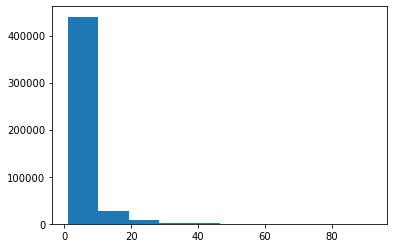

In [160]:
# 유저별 unique 방문 일자 히스토그램 확인

plt.hist(use_day.고유_일자)

<BarContainer object of 92 artists>

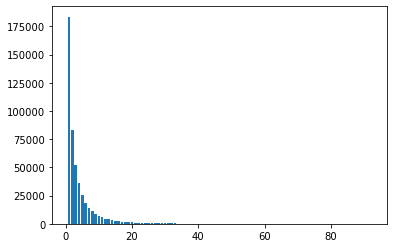

In [161]:
# 유저별 unique 방문 일자별 bar plot 확인

use_day_ratio = use_day.groupby("고유_일자").nunique("유저_번호").reset_index()
plt.bar(use_day_ratio.고유_일자, use_day_ratio.유저_번호)

In [162]:
# 이상치 있는지 확인 위해서 일코드_cnt 기준으로 내림차순 정렬

use_day.sort_values("고유_일자", ascending = False).head(5)

,유저_번호,고유_일자
127244,232737,92
247843,454280,92
431531,791240,92
111039,203116,91
205967,377301,91


In [163]:
# 고유일자 가 가장 많은 유저 번호은 454280 유저가 혹시 QA 를 위한 유저가 아닌지 행동패턴 이상 여부 확인 -> 이상 없음.

pd.set_option('display.max_rows', 100)
log_data[log_data["유저_번호"]==454280].sort_values("행동일시").head(20)

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초
12156093,454280,GetCreditInfo,KCB_신용정보_조회,2022-03-01 05:08:02,iOS,3.6.0,2022-03-01,2022,3,1,5,8,2
589877,454280,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-01 05:08:07,iOS,3.6.0,2022-03-01,2022,3,1,5,8,7
589878,454280,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-01 05:08:08,iOS,3.6.0,2022-03-01,2022,3,1,5,8,8
589879,454280,CompleteIDCertification,본인인증완료,2022-03-01 05:08:29,iOS,3.6.0,2022-03-01,2022,3,1,5,8,29
589880,454280,EndLoanApply,한도조회_결과_확인,2022-03-01 05:09:41,iOS,3.6.0,2022-03-01,2022,3,1,5,9,41
12156107,454280,GetCreditInfo,KCB_신용정보_조회,2022-03-01 05:11:01,iOS,3.6.0,2022-03-01,2022,3,1,5,11,1
5368708,454280,OpenApp,앱_실행,2022-03-02 06:41:02,iOS,3.6.0,2022-03-02,2022,3,2,6,41,2
5368709,454280,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-02 06:41:13,iOS,3.6.0,2022-03-02,2022,3,2,6,41,13
5368710,454280,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-02 06:41:13,iOS,3.6.0,2022-03-02,2022,3,2,6,41,13
5368713,454280,CompleteIDCertification,본인인증완료,2022-03-02 06:41:34,iOS,3.6.0,2022-03-02,2022,3,2,6,41,34


### 유저 첫_로그_일자 & 마지막_로그_일자

In [164]:
# 유저별 로그 데이터 기준 가장 처음의 로그 일자와 마지막 로그일자를 컬럼으로 생성

# 첫 로그 일자
first_log = log_data_dev.groupby("유저_번호")["일_코드"].min().reset_index()
first_log.columns = ["유저_번호", "첫_로그_일자"]

# 마지막 로그 일자
last_log = log_data_dev.groupby("유저_번호")["일_코드"].max().reset_index()
last_log.columns = ["유저_번호", "마지막_로그_일자"]

# use_day 기준으로 두 컬럼 모두 merge
action_cnt = pd.merge(use_day, first_log, on = "유저_번호", how = "left")
action_cnt = pd.merge(action_cnt, last_log, on = "유저_번호", how = "left")
action_cnt = pd.merge(action_cnt, log_data_dev[["유저_번호","운영체제_갯수"]].drop_duplicates(), on = "유저_번호", how = "left")
action_cnt.head()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수
0,1,1,2022-05-03,2022-05-03,1
1,7,1,2022-05-22,2022-05-22,1
2,9,1,2022-05-21,2022-05-21,1
3,11,2,2022-03-24,2022-04-20,1
4,12,10,2022-03-14,2022-05-19,1


In [165]:
log_data_dev[log_data_dev["유저_번호"]==19]

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초,운영체제_갯수
2181732,19,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-05-14 00:55:30,iOS,3.10.2,2022-05-14,2022,5,14,0,55,30,1
2181733,19,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-05-14 00:55:30,iOS,3.10.2,2022-05-14,2022,5,14,0,55,30,1
2181736,19,CompleteIDCertification,본인인증완료,2022-05-14 00:55:54,iOS,3.10.2,2022-05-14,2022,5,14,0,55,54,1
2181738,19,EndLoanApply,한도조회_결과_확인,2022-05-14 00:56:59,iOS,3.10.2,2022-05-14,2022,5,14,0,56,59,1


### 이벤트별 count

In [166]:
# 각 행동명 action 수에 따른 count

action_log = action_cnt

for i in log_data_dev["행동명_kor"].unique() :
    globals()['log_'+str(i)]  = log_data_dev[log_data_dev["행동명_kor"] == f"{i}"].groupby("유저_번호")["행동명_kor"].count().reset_index()
    globals()['log_'+str(i)].columns = ["유저_번호", i]
    action_log = pd.merge(action_log, globals()['log_'+str(i)], on = "유저_번호", how = 'left')

# 전체 액션 count

log_total = log_data_dev.groupby("유저_번호")["행동명_kor"].count().reset_index()
log_total.columns = ["유저_번호","전체_이벤트"]
action_log = pd.merge(action_log, log_total, on = "유저_번호", how = "left")

print(action_log.head())

   유저_번호  고유_일자     첫_로그_일자   마지막_로그_일자  운영체제_갯수  한도조회_시작하기_버튼_클릭  \
0      1      1  2022-05-03  2022-05-03        1              nan   
1      7      1  2022-05-22  2022-05-22        1              nan   
2      9      1  2022-05-21  2022-05-21        1              nan   
3     11      2  2022-03-24  2022-04-20        1          2.00000   
4     12     10  2022-03-14  2022-05-19        1         11.00000   

   한도조회_인트로_페이지_조회  한도조회_결과_확인     앱_실행  대출관리_서비스_이용  여윳돈_계산기_서비스_이용      로그인  \
0              nan         nan      nan          nan             nan      nan   
1              nan         nan      nan          nan             nan      nan   
2              nan         nan      nan          nan             nan      nan   
3          3.00000     5.00000  3.00000      7.00000         1.00000      nan   
4         11.00000    24.00000 11.00000      1.00000             nan 11.00000   

    본인인증완료  DSR_계산기_서비스_이용  회원가입  KCB_신용정보_조회  전체_이벤트  
0      nan             nan   nan      2.00

In [167]:
# 19 의 CASE 로 확인.

# log_data[log_data["유저_번호"]==19]
action_log[action_log["유저_번호"]==19]
# action_cnt[action_cnt["유저_번호"]==19]

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트
6,19,1,2022-05-14,2022-05-14,1,1.00000,1.00000,1.00000,nan,nan,nan,nan,1.00000,nan,nan,nan,4


In [168]:
# 결측치 확인 : 이벤트 count 가 null 인 유저는 해당 이벤트를 하지 않음 -> 0으로 대체
action_log.isnull().sum()

유저_번호                   0
고유_일자                   0
첫_로그_일자                 0
마지막_로그_일자               0
운영체제_갯수                 0
한도조회_시작하기_버튼_클릭    211246
한도조회_인트로_페이지_조회    187544
한도조회_결과_확인         230502
앱_실행               126061
대출관리_서비스_이용        234058
여윳돈_계산기_서비스_이용     475396
로그인                192815
본인인증완료             223767
DSR_계산기_서비스_이용     476248
회원가입               459510
KCB_신용정보_조회        112876
전체_이벤트                  0
dtype: int64

In [169]:
# 결측치 처리 -> 0
action_log.fillna(0, inplace = True)

In [170]:
# 결측치 처리 확인
action_log.isnull().sum()

유저_번호              0
고유_일자              0
첫_로그_일자            0
마지막_로그_일자          0
운영체제_갯수            0
한도조회_시작하기_버튼_클릭    0
한도조회_인트로_페이지_조회    0
한도조회_결과_확인         0
앱_실행               0
대출관리_서비스_이용        0
여윳돈_계산기_서비스_이용     0
로그인                0
본인인증완료             0
DSR_계산기_서비스_이용     0
회원가입               0
KCB_신용정보_조회        0
전체_이벤트             0
dtype: int64

### 첫 한도조회 결과 확인 일자 (조회 전환 기간)

In [171]:
# 유저별 가장 처음 한도 조회 결과를 한 일자 확인
main_event = log_data_dev[log_data_dev["행동명_kor"]=="한도조회_결과_확인"].groupby("유저_번호")["행동일시"].min().reset_index()

# 해당 한도 조회 결과를 한 행동 일시에서 일자만을 확인 (yyyy-mm-dd)
main_event["행동일시"] =  main_event.행동일시.str[0:10]

# 컬럼 명 변경
main_event.columns = ["유저_번호","첫_한도조회_결과_확인_일자"]

In [172]:
# action_log 에 해당 데이터 병합
action_log_temp = pd.merge(action_log, main_event, on = "유저_번호", how = "left")
action_log_temp[action_log_temp["유저_번호"]==19]

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,첫_한도조회_결과_확인_일자
6,19,1,2022-05-14,2022-05-14,1,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,4,2022-05-14


### 첫 로그 일자 = 220531 - 첫 로그 일자 + 1
### 마지막 로그 일자 = 220531 - 마지막 로그 일자 + 1
### 조회_전환_기간 = 첫 한도조회 결과 확인 일자 - 첫 로그 일자 + 1

In [173]:
action_log_temp["조회_전환_시간"] = pd.to_datetime(action_log_temp["첫_한도조회_결과_확인_일자"]) -  pd.to_datetime(action_log_temp["첫_로그_일자"])
action_log_temp["첫_로그_일자"]=datetime.strptime("2022531", "%Y%m%d")  - pd.to_datetime(action_log_temp["첫_로그_일자"])
action_log_temp["마지막_로그_일자"]=datetime.strptime("2022531", "%Y%m%d") - pd.to_datetime(action_log_temp["마지막_로그_일자"])

In [174]:
action_log_temp.drop("첫_한도조회_결과_확인_일자",axis = 1,inplace = True)
action_log_temp[action_log_temp["유저_번호"]==19]

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,조회_전환_시간
6,19,1,17 days,17 days,1,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,4,0 days


In [175]:
action_log_temp[["첫_로그_일자","마지막_로그_일자","조회_전환_시간"]].isnull().sum()

첫_로그_일자           0
마지막_로그_일자         0
조회_전환_시간     230502
dtype: int64

<BarContainer object of 92 artists>

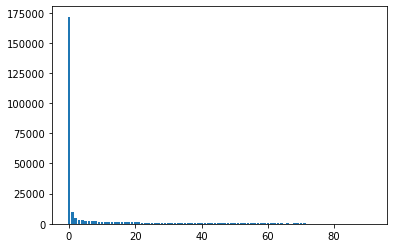

In [176]:
temp= action_log_temp["조회_전환_시간"].dt.days.reset_index().groupby("조회_전환_시간").count().reset_index()
temp.columns= ["조회_전환_시간","cnt"]
plt.bar(temp.조회_전환_시간, temp.cnt)

In [177]:
action_log_temp["첫_로그_일자"] = action_log_temp["첫_로그_일자"].dt.days + 1
action_log_temp["마지막_로그_일자"] = action_log_temp["마지막_로그_일자"].dt.days + 1
action_log_temp["조회_전환_시간"] = action_log_temp["조회_전환_시간"].dt.days + 1
# action_log_temp[action_log_temp["유저_번호"]==19]

In [178]:
action_log_check_point = action_log
action_log_check_point.head() # 임시 저장

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트
0,1,1,2022-05-03,2022-05-03,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,2
1,7,1,2022-05-22,2022-05-22,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1
2,9,1,2022-05-21,2022-05-21,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,3
3,11,2,2022-03-24,2022-04-20,1,2.00000,3.00000,5.00000,3.00000,7.00000,1.00000,0.00000,2.00000,0.00000,0.00000,8.00000,31
4,12,10,2022-03-14,2022-05-19,1,11.00000,11.00000,24.00000,11.00000,1.00000,0.00000,11.00000,10.00000,0.00000,0.00000,3.00000,82


In [179]:
# action_log_temp = action_log_check_point # 임시 저장 불러오기

In [180]:
action_log = action_log_temp

In [181]:
action_log[action_log["유저_번호"]==19].head()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,조회_전환_시간
6,19,1,18,18,1,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,4,1.00000


## 이상치 확인

### 앱 실행이 아예 없는 유저 확인

In [182]:
# 앱 실행 없는 유저의 이벤트별 describe
action_log[action_log["앱_실행"] == 0].describe()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,조회_전환_시간
count,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,126061.00000,32325.00000
mean,440058.45422,1.13896,42.17891,40.08740,1.00778,0.37409,0.40307,0.42096,0.00000,0.26351,0.00402,0.32994,0.31690,0.00267,0.04049,1.42889,3.58455,2.85596
std,254188.55674,0.41279,25.84493,25.77297,0.08850,0.70100,0.73090,0.95735,0.00000,0.73859,0.08482,0.48092,0.56898,0.05506,0.20418,1.26371,3.42252,8.05714
min,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
25%,219938.00000,1.00000,20.00000,17.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
50%,440483.00000,1.00000,41.00000,39.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,2.00000,1.00000
75%,660704.00000,1.00000,63.00000,61.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,2.00000,5.00000,1.00000
max,879695.00000,15.00000,92.00000,92.00000,3.00000,13.00000,13.00000,17.00000,0.00000,44.00000,6.00000,5.00000,11.00000,3.00000,3.00000,46.00000,130.00000,89.00000


In [183]:
# 전체 유저의 이벤트별 describe
action_log.describe()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,조회_전환_시간
count,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,479773.00000,249271.00000
mean,439603.61706,4.11315,56.49935,30.91484,1.01310,2.91612,2.74629,3.58815,5.15684,2.39248,0.01474,3.71081,1.89188,0.00946,0.05117,3.71367,26.19162,7.55408
std,253983.06424,5.64899,27.51270,25.89009,0.11444,6.82306,5.89769,9.31769,10.86991,6.48014,0.20773,9.10970,4.36942,0.13771,0.28956,8.57538,52.78169,15.13331
min,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
25%,219490.00000,1.00000,35.00000,8.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,3.00000,1.00000
50%,439804.00000,2.00000,61.00000,23.00000,1.00000,1.00000,1.00000,1.00000,2.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,2.00000,10.00000,1.00000
75%,659556.00000,5.00000,82.00000,48.00000,1.00000,3.00000,3.00000,3.00000,6.00000,2.00000,0.00000,4.00000,2.00000,0.00000,0.00000,4.00000,28.00000,4.00000
max,879698.00000,92.00000,92.00000,92.00000,3.00000,511.00000,534.00000,1214.00000,1353.00000,972.00000,25.00000,855.00000,520.00000,23.00000,36.00000,1001.00000,4111.00000,92.00000


In [184]:
pd.options.display.float_format = '{:.5f}'.format
print("앱 실행 0 인 유저들의 고유 일자별 비율")
action_log[action_log["앱_실행"] == 0].groupby("고유_일자").count()["유저_번호"] / action_log[action_log["앱_실행"] == 0].count()["유저_번호"] * 100

앱 실행 0 인 유저들의 고유 일자별 비율


고유_일자
1    87.74006
2    11.08432
3     0.90908
4     0.17452
5     0.04363
6     0.02776
7     0.00793
8     0.00555
9     0.00238
10    0.00159
11    0.00159
14    0.00079
15    0.00079
Name: 유저_번호, dtype: float64

In [185]:
pd.options.display.float_format = '{:.5f}'.format
print("앱 실행 0 인 유저들의 고유 일자별 전체 유저 대비 비율")
action_log[action_log["앱_실행"] == 0].groupby("고유_일자").count()["유저_번호"] / action_log.count()["유저_번호"] * 100

# 차라리 일 코드 1일인 애들은 맨 앞에 한번만 앱실행을 넣어주고, 2일 이상인 애들은 드랍하는게 어떨지..?

앱 실행 0 인 유저들의 고유 일자별 전체 유저 대비 비율


고유_일자
1    23.05382
2     2.91242
3     0.23886
4     0.04586
5     0.01146
6     0.00730
7     0.00208
8     0.00146
9     0.00063
10    0.00042
11    0.00042
14    0.00021
15    0.00021
Name: 유저_번호, dtype: float64

In [186]:
action_log[action_log["앱_실행"] == 0].count()

유저_번호              126061
고유_일자              126061
첫_로그_일자            126061
마지막_로그_일자          126061
운영체제_갯수            126061
한도조회_시작하기_버튼_클릭    126061
한도조회_인트로_페이지_조회    126061
한도조회_결과_확인         126061
앱_실행               126061
대출관리_서비스_이용        126061
여윳돈_계산기_서비스_이용     126061
로그인                126061
본인인증완료             126061
DSR_계산기_서비스_이용     126061
회원가입               126061
KCB_신용정보_조회        126061
전체_이벤트             126061
조회_전환_시간            32325
dtype: int64

In [187]:
pd.options.display.float_format = '{:.5f}'.format
print("앱 실행 0이 아닌 유저들의 고유 일자별 비율")
temp = action_log[action_log["앱_실행"] != 0].groupby("고유_일자").count()["유저_번호"] / action_log[action_log["앱_실행"] != 0].count()["유저_번호"] * 100
temp.head(20)

앱 실행 0이 아닌 유저들의 고유 일자별 비율


고유_일자
1    20.61423
2    19.50231
3    14.41681
4    10.10992
5     7.29944
6     5.23166
7     3.98234
8     3.14210
9     2.48818
10    1.95441
11    1.58123
12    1.29936
13    1.09524
14    0.92024
15    0.80461
16    0.63102
17    0.56967
18    0.48966
19    0.44132
20    0.34491
Name: 유저_번호, dtype: float64

In [188]:
action_log[action_log["앱_실행"] == 0].groupby("전체_이벤트").count()["유저_번호"] / action_log[action_log["앱_실행"] == 0].count()["유저_번호"] * 100

전체_이벤트
1     32.74684
2     17.51057
3     12.36703
4     11.37307
5      6.69121
6      5.00631
7      3.80213
8      2.70504
9      2.00062
10     1.43423
11     1.05266
12     0.77661
13     0.55449
14     0.44820
15     0.30223
16     0.25385
17     0.18721
18     0.16500
19     0.12058
20     0.09123
21     0.06822
22     0.06425
23     0.04839
24     0.04918
25     0.03332
26     0.02380
27     0.02142
28     0.02142
29     0.01349
30     0.01031
31     0.00555
32     0.00873
33     0.00238
34     0.00555
35     0.00635
36     0.00476
37     0.00159
38     0.00079
39     0.00079
41     0.00317
42     0.00317
43     0.00159
44     0.00079
45     0.00079
46     0.00079
47     0.00079
48     0.00159
50     0.00238
51     0.00159
57     0.00079
58     0.00079
61     0.00079
70     0.00079
130    0.00079
Name: 유저_번호, dtype: float64

In [189]:
# 앱 실행은 없지만, 전체 이벤는 158개인 유저 확인
action_log[(action_log["앱_실행"] == 0) & (action_log["전체_이벤트"] == 130)]

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,조회_전환_시간
431769,791674,5,68,58,1,1.00000,11.00000,13.00000,0.00000,44.00000,6.00000,0.00000,7.00000,2.00000,0.00000,46.00000,130,1.00000


In [190]:
# 앱 실행은 없지만, 전체 이벤는 158개인 유저의 raw log 확인
log_data[log_data["유저_번호"] == 791674].sort_values("행동일시").to_csv("791674_case_check.csv")

In [191]:
log_data[log_data["행동명_kor"] == "앱_실행"].sort_values(["유저_번호","행동일시"])

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초
9505105,11,OpenApp,앱_실행,2022-03-24 10:53:59,iOS,3.6.1,2022-03-24,2022,3,24,10,53,59
8380001,11,OpenApp,앱_실행,2022-04-20 10:04:10,iOS,3.7.0,2022-04-20,2022,4,20,10,4,10
8380067,11,OpenApp,앱_실행,2022-04-20 10:39:55,iOS,3.7.0,2022-04-20,2022,4,20,10,39,55
2021868,11,OpenApp,앱_실행,2022-06-09 11:23:18,iOS,NaN,2022-06-09,2022,6,9,11,23,18
3550216,11,OpenApp,앱_실행,2022-06-13 21:43:01,iOS,NaN,2022-06-13,2022,6,13,21,43,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768418,879693,OpenApp,앱_실행,2022-06-26 13:08:06,iOS,3.13.0,2022-06-26,2022,6,26,13,8,6
15387184,879693,OpenApp,앱_실행,2022-06-27 10:13:48,iOS,3.13.0,2022-06-27,2022,6,27,10,13,48
4119911,879693,OpenApp,앱_실행,2022-06-29 17:20:45,iOS,3.13.1,2022-06-29,2022,6,29,17,20,45
7298668,879696,OpenApp,앱_실행,2022-03-14 05:37:32,Android,3.8.2,2022-03-14,2022,3,14,5,37,32


In [192]:
action_log[action_log["유저_번호"]==19]

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,조회_전환_시간
6,19,1,18,18,1,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,4,1.00000


In [193]:
action_log.to_csv("../data/action_log_.csv")

In [194]:
action_log = pd.read_csv("../data/action_log_.csv",index_col = 0) # 중간부터 불러오기

In [195]:
action_log[action_log["유저_번호"]==19].head()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,조회_전환_시간
6,19,1,18,18,1,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,4,1.00000


## 앱 실행 == session 으로 추가 변수 제작

In [196]:
# 앱 실행을 session 으로 볼수 있다면 ? 

action_log_temp = action_log.drop(action_log[(action_log["앱_실행"] == 0) & (action_log["고유_일자"]  > 1)].index) # 앱 실행 = 0 고유일자 > 1 인 애들은 drop
action_log_temp["앱_실행"].replace(0,1, inplace=True) # 앱 실행 = 0 고유일자 = 1 인 애들한테는 임의로 앱 실행 1 부여
action_log_temp.head()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,조회_전환_시간
0,1,1,29,29,1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,2,nan
1,7,1,10,10,1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1,nan
2,9,1,11,11,1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,3,nan
3,11,2,69,42,1,2.00000,3.00000,5.00000,3.00000,7.00000,1.00000,0.00000,2.00000,0.00000,0.00000,8.00000,31,1.00000
4,12,10,79,13,1,11.00000,11.00000,24.00000,11.00000,1.00000,0.00000,11.00000,10.00000,0.00000,0.00000,3.00000,82,1.00000


In [197]:
action_log_temp["방문일자비율"] = action_log_temp["고유_일자"] / action_log_temp["첫_로그_일자"]
action_log_temp["앱실행비율"] = action_log_temp["앱_실행"] / action_log_temp["첫_로그_일자"]
action_log_temp.head()

,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,한도조회_시작하기_버튼_클릭,한도조회_인트로_페이지_조회,한도조회_결과_확인,앱_실행,대출관리_서비스_이용,여윳돈_계산기_서비스_이용,로그인,본인인증완료,DSR_계산기_서비스_이용,회원가입,KCB_신용정보_조회,전체_이벤트,조회_전환_시간,방문일자비율,앱실행비율
0,1,1,29,29,1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,2,nan,0.03448,0.03448
1,7,1,10,10,1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1,nan,0.10000,0.10000
2,9,1,11,11,1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,3,nan,0.09091,0.09091
3,11,2,69,42,1,2.00000,3.00000,5.00000,3.00000,7.00000,1.00000,0.00000,2.00000,0.00000,0.00000,8.00000,31,1.00000,0.02899,0.04348
4,12,10,79,13,1,11.00000,11.00000,24.00000,11.00000,1.00000,0.00000,11.00000,10.00000,0.00000,0.00000,3.00000,82,1.00000,0.12658,0.13924


In [198]:
action_log_temp_b = action_log_temp.copy()

In [199]:
action_event = action_log_temp[["유저_번호","전체_이벤트"]]
action_event

,유저_번호,전체_이벤트
0,1,2
1,7,1
2,9,3
3,11,31
4,12,82
...,...,...
479768,879693,38
479769,879694,4
479770,879695,4
479771,879696,11


In [200]:
action_cnt_app_open = action_log_temp

for i in action_cnt_app_open.columns[5:16] :
    if i != "앱_실행":
        try : 
            action_cnt_app_open["세션당_"+str(i)] = action_cnt_app_open[str(i)] / action_cnt_app_open["앱_실행"]
        except  : continue
        action_cnt_app_open.drop(str(i),axis=1,inplace = True)
    print(i)

action_cnt_app_open = pd.merge(action_cnt_app_open,action_event,on="유저_번호",how="left")    
action_cnt_app_open
    
    
#     action_log = action_cnt
# for i in log_data["행동명_kor"].unique() :
#     globals()['log_'+str(i)]  = log_data[log_data["행동명_kor"] == f"{i}"].groupby("유저_번호")["행동명_kor"].count().reset_index()
#     globals()['log_'+str(i)].columns = ["유저_번호", i]
#     action_log = pd.merge(action_log, globals()['log_'+str(i)], on = "유저_번호", how = 'left')

한도조회_시작하기_버튼_클릭
한도조회_인트로_페이지_조회
한도조회_결과_확인
앱_실행
대출관리_서비스_이용
여윳돈_계산기_서비스_이용
로그인
본인인증완료
DSR_계산기_서비스_이용
회원가입
KCB_신용정보_조회


,유저_번호,고유_일자,첫_로그_일자,마지막_로그_일자,운영체제_갯수,앱_실행,전체_이벤트_x,조회_전환_시간,방문일자비율,앱실행비율,...,세션당_한도조회_인트로_페이지_조회,세션당_한도조회_결과_확인,세션당_대출관리_서비스_이용,세션당_여윳돈_계산기_서비스_이용,세션당_로그인,세션당_본인인증완료,세션당_DSR_계산기_서비스_이용,세션당_회원가입,세션당_KCB_신용정보_조회,전체_이벤트_y
0,1,1,29,29,1,1.00000,2,nan,0.03448,0.03448,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,2
1,7,1,10,10,1,1.00000,1,nan,0.10000,0.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1
2,9,1,11,11,1,1.00000,3,nan,0.09091,0.09091,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,3
3,11,2,69,42,1,3.00000,31,1.00000,0.02899,0.04348,...,1.00000,1.66667,2.33333,0.33333,0.00000,0.66667,0.00000,0.00000,2.66667,31
4,12,10,79,13,1,11.00000,82,1.00000,0.12658,0.13924,...,1.00000,2.18182,0.09091,0.00000,1.00000,0.90909,0.00000,0.00000,0.27273,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464313,879693,3,19,12,1,4.00000,38,1.00000,0.15789,0.21053,...,1.25000,2.25000,0.75000,0.00000,0.00000,1.00000,0.00000,0.00000,0.25000,38
464314,879694,1,62,62,1,1.00000,4,1.00000,0.01613,0.01613,...,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,4
464315,879695,1,5,5,1,1.00000,4,1.00000,0.20000,0.20000,...,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,4
464316,879696,1,79,79,1,1.00000,11,1.00000,0.01266,0.01266,...,1.00000,1.00000,2.00000,0.00000,2.00000,1.00000,0.00000,0.00000,3.00000,11


In [67]:
action_cnt_app_open.to_csv("../data/action_cnt_app_open_6_ext.csv") # 해당 파생 변수 제작 데이터 셋 export  _ action_cnt_app_open_6_ext

---